<h1>Nettoyage des commentaires</h1>

Avant de pouvoir faire de l'analyse de sentiment pour chaque commentaire, il faut d'abord les nettoyer pour les rendre lisibles pour l'ordinateur. Premièrement, nous allons transformer le fichier data_reviews en une base de données où chaque observation est un commentaire. Puis, nous allons nettoyer chaque commentaire en utilisant des fonctions permettant de supprimer la ponctuation, les stop-words et la lemmatisation.



In [6]:
# Importation de packages nécessaires

import pandas as pd
import json
import nltk
import spacy
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

<h2>Création de la base de données des commentaires</h2>

In [7]:
# Transformation du fichier json en un Dataframe Pandas

# Charger le fichier JSON
with open("C:/Users/USER/Desktop/Projet Python/Projet_Python/data_reviews.json", 'r') as file:
    data = json.load(file)


In [8]:
movie_name = []
comments = []
notes = []

for movie, dico in data.items():
    if '0' in dico and isinstance(dico['0'], list):  # Vérifier si la clé '0' est une liste
        for comment in dico['0']:
            movie_name.append(movie)
            comments.append(comment)
            notes.append(dico['1'])

df = pd.DataFrame({
    'Film': movie_name,
    'Commentaire': comments,
    'Note imdb': notes
})

df.sample(5)

,Film,Commentaire,Note imdb
3174,Captain Marvel,I'm not familiar with the character of Captain...,"6,8"
63,Avatar,As soon as i watched this movie back then when...,"7,9"
2748,Captain America: Civil War,"By far, this is the widest, deepest, most-deta...","7,8"
510,Avengers: Infinity War,Avengers: Infinity War is a film that should b...,"8,4"
3581,The Dark Knight Rises,what can I say that has not said before??\n\nI...,"8,4"


<h2>Nettoyage des commentaires</h2>

In [9]:
# Téléchargement d'éléments nécessaires à la tokenisation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Tokenisation et suppression de la ponctuation

# On commence par charger le modèle de la langue anglaise de Spacy (les commentaires sont en anglais)
nlp = spacy.load('en_core_web_sm')

# Fonction qui prend en argument un commentaire (chaîne de caractère) et qui retourne une liste des tokens sans les stopwords et la ponctuation
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return tokens


In [11]:
# On crée une nouvelle colonne dans la bdd avec la liste des tokens pour chaque commentaire
df['Tokens'] = df['Commentaire'].apply(tokenize)
df.sample(5)

,Film,Commentaire,Note imdb,Tokens
379,Titanic,"One of The best movies ive seen, 10/10 and Peo...","7,9","[best, movies, ve, seen, 10/10, People, ok, mo..."
4427,"Star Wars, épisode I : La Menace fantôme",The Phantom Menace is one of those movies that...,"6,5","[Phantom, Menace, movies, meaning, review, saw..."
1916,La Reine des neiges,Amazing movie. It has everything fantastic sto...,"7,4","[Amazing, movie, fantastic, story(rememberable..."
3087,Spider-Man: Far From Home,Plot writing was great and engaging. For those...,"7,4","[Plot, writing, great, engaging, lot, question..."
674,Spider-Man: No Way Home,After the third phase of Marvel Cinematic Univ...,"8,2","[phase, Marvel, Cinematic, Universe, franchise..."


Avec Spacy, l'algortihme s'exécute en près de 6 min pour l'ensemble de la base de données. Nous avons utilisé Spacy et non nltk pour la tokenization et la suppression des stopwords, puisque Spacy a un répertoire plus important de stopwords et a de meilleures performances pour les textes volumineux.

Nous allons désormais procéder à la lemmatisation des commentaires pour pouvoir allèger les algorithmes de NLP plus tard.

In [12]:
# Fonction qui prend en argument une liste de tokens et qui retourne ces tokens lemmatisés
def lemm(tokens):
    # D'abord, on transforme la liste en doc Spacy
    tokens_as_doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    # Lemmatisation du doc 
    lemmatized = [token.lemma_ for token in tokens_as_doc]
    return lemmatized
# Le lemma_ de Spacy ne reconnait pas les tokens et renvoie des listes vides (Pourquoi ?)

lemmatizer = WordNetLemmatizer()

def lemm2(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [13]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)

df.sample(5)

,Film,Commentaire,Note imdb,Tokens,Tokens lemmatisés
4679,Alice au pays des merveilles,"As an ""Alice"" purist I generally cringe at the...","6,4","[Alice, purist, generally, cringe, assortment,...","[Alice, purist, generally, cringe, assortment,..."
2171,La Belle et la Bête,"It's been a tale as old as time, a song as old...","7,1","[tale, old, time, song, old, rhyme, Beauty, Be...","[tale, old, time, song, old, rhyme, Beauty, Be..."
496,"Star Wars, épisode VII : Le Réveil de la Force",It's over 30 years since the defeat of the emp...,"7,8","[30, years, defeat, empire, Republic, threaten...","[30, year, defeat, empire, Republic, threatene..."
1922,La Reine des neiges,Back when Frozen first came out on thanksgivin...,"7,4","[Frozen, came, thanksgiving, weekend, 2013, ex...","[Frozen, came, thanksgiving, weekend, 2013, ex..."
2473,Iron Man 3,"For starters, tony starks character just keeps...","7,1","[starters, tony, starks, character, keeps, get...","[starter, tony, starks, character, keep, getti..."


<h2>Représentation des mots</h2>

Maintenant, visualisons pour certains commentaires les mots les plus représentés après nettoyage des commentaires.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [14]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud


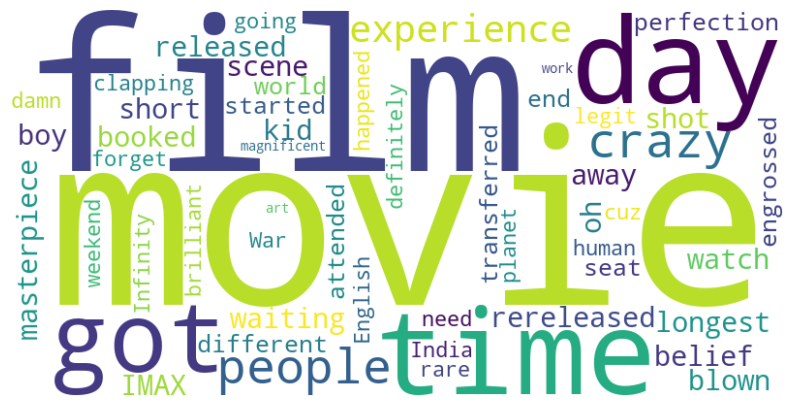

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... .